In [1]:
ALGORITHM = 'XG Boost'
#ALGORITHM = 'Linear Regression (Ridge)'
#ALGORITHM = 'KNN'
#ALGORITHM = 'Decision Tree'
#ALGORITHM = 'Random Forest'
#ALGORITHM = 'CatBoost'

ALGORITHM_DETAIL = 'random search'
DATA_DETAIL = []
#DATA_DETAIL = ['no scale','no dummies']
#DATA_DETAIL = ['no dummies']
VERSION = '06'

RANDOM_STATE = 101
TRAINING_SIZE = 0.9

CROSS_VALIDATION_SCORING = 'r2'

print(f'ALGORITHM: {ALGORITHM}')
print(f'ALGORITHM_DETAIL: {ALGORITHM_DETAIL}')
print(f'DATA_DETAIL: {DATA_DETAIL}')
print(f'DATA VERSION: {VERSION}')


ALGORITHM: XG Boost
ALGORITHM_DETAIL: random search
DATA_DETAIL: []
DATA VERSION: 06


In [2]:
%pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 24.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 87.8 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
from sklearn.impute import SimpleImputer
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import numpy as np
from pandas import DataFrame
import math
from termcolor import colored
from time import time
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score
import seaborn as sns
import pickle

import json
from datetime import datetime
import matplotlib.pyplot as plt

with open('../../z_envs/_envs.json') as f:
    env_vars = json.loads(f.read())
print(env_vars)

try:
    import google.colab

    run_env = 'colab'
except:
    try:
        run_env = env_vars['notebook_environment']
    except:
        run_env = 'unknown'

use_gpu = env_vars.get('use_gpu', False)
debug_mode = env_vars.get('debug_mode', False)
quick_mode = env_vars.get('quick_mode', False)
OVERRIDE_CV = env_vars.get('quick_override_cv_splits', None) if quick_mode else None
OVERRIDE_N_ITER = env_vars.get('quick_override_n_iter', None) if quick_mode else None
OVERRIDE_JOBS = env_vars.get('quick_override_n_jobs', None) if quick_mode else None
#if quick_mode:OVERRIDE_CV, OVERRIDE_N_ITER = 2, 10

already_timed = False
no_dummies = 'no dummies' in DATA_DETAIL
no_scaling = 'no scaling' in DATA_DETAIL
not_catboost = 'catboost' not in ALGORITHM.lower() or not no_dummies

if run_env not in ['colab', 'gradient', 'cloud']:
    cloud_run = False
    from functions_20221109 import set_csv_directory, get_columns
    from functions_modelling_20221109 import make_modelling_pipeline, tidy_dataset, preprocess, feature_engineer, create_train_test_data
    from functions_modelling_20221109 import get_cv_params, fit_model_with_cross_validation, get_best_estimator_average_time
    from functions_modelling_20221109 import get_results, update_results, get_chosen_model
    from functions_modelling_20221109 import get_hyperparameters

    set_csv_directory('final_split')
else:
    cloud_run = True
    import sys
    import os

    module_path = os.path.abspath(os.path.join('..', '..', '..'))
    if module_path not in sys.path:
        #sys.path.append(module_path+"\\zfunctions")
        sys.path.append(module_path)

    from functions_20221109 import set_csv_directory, get_columns
    #from functions_20221109 import add_supplements, get_combined_dataset
    from functions_modelling_20221109 import make_modelling_pipeline, tidy_dataset, preprocess, feature_engineer, create_train_test_data
    from functions_modelling_20221109 import get_cv_params, fit_model_with_cross_validation, get_best_estimator_average_time
    from functions_modelling_20221109 import get_results, update_results, get_chosen_model
    from functions_modelling_20221109 import get_hyperparameters


{'notebook_environment': 'gradient', 'use_gpu': True, 'debug_mode': False, 'quick_mode': False, 'quick_override_cv_splits': 2, 'quick_override_n_iter': 10, 'quick_override_n_jobs': 3}


In [4]:
#cutdown_rows = 1000
cutdown_rows = 0

LABEL = 'Price'

columns, booleans, floats, categories, custom, wildcard = get_columns(version=VERSION)

print(colored(f"features", "blue"), "-> ", columns)
columns.insert(0, LABEL)
print(colored(f"label", "green", None, ['bold']), "-> ", LABEL)

features ->  ['bedrooms', 'bathrooms', 'nearestStation', 'location.latitude', 'location.longitude', 'latitude_deviation', 'longitude_deviation', 'tenure.tenureType']
label ->  Price


In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler


def make_pipeline():
    return Pipeline([
        #('mms', MinMaxScaler()),
        ('std_scaler', StandardScaler()),
        ('model', get_chosen_model(ALGORITHM))
    ])


starter_pipe = make_pipeline()
starter_pipe

Pipeline(steps=[('std_scaler', StandardScaler()),
                ('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              gamma=None, gpu_id=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=None,
                              max_leaves=None, min_child_weight=None,
                              missing=nan, monotone_constraints=None,
                              n_estimators=100, n_jobs=None,
                              num_parallel_tree=None, predictor=None,
                              random_state=None, reg_alpha=None,
                              reg_lambda=None, ...))])

In [6]:
def get_source_dataframe(rows=cutdown_rows, folder_prefix='../../../'):
    retrieval_type = None

    filename = f'df_listings_v{VERSION}.csv'
    remote_pathname = f'https://raw.githubusercontent.com/jayportfolio/capstone_streamlit/main/data/final/{filename}'
    df_pathname_raw = folder_prefix + f'data/source/{filename}'
    df_pathname_tidy = folder_prefix + f'data/final/{filename}'

    if cloud_run:
        inDF = pd.read_csv(remote_pathname, on_bad_lines='error', index_col=0)
        retrieval_type = 'tidy'
        print('loaded data from', folder_prefix + remote_pathname)
    else:
        inDF = pd.read_csv(df_pathname_tidy, on_bad_lines='error', index_col=0)
        retrieval_type = 'tidy'
        print('loaded data from', df_pathname_tidy)

    if rows and rows > 0:
        inDF = inDF[:rows]
    return inDF, retrieval_type

In [7]:
df, retrieval_type = get_source_dataframe(folder_prefix='../../../')
df_orig = df.copy()

if retrieval_type != 'tidy':
    df = tidy_dataset(df, version=int(VERSION))
    df = feature_engineer(df, version=int(VERSION))

    df = df[columns]

print(df.shape)

loaded data from ../../../https://raw.githubusercontent.com/jayportfolio/capstone_streamlit/main/data/final/df_listings_v06.csv
(46871, 9)


In [8]:
df.head(30)

,Price,bedrooms,bathrooms,nearestStation,location.latitude,location.longitude,latitude_deviation,longitude_deviation,tenure.tenureType
14520525,550000.0,3.0,1.0,0.274316,51.529950,-0.207020,0.030230,0.102600,LEASEHOLD
27953107,400000.0,2.0,2.0,0.305845,51.549390,-0.482600,0.049670,0.378180,LEASEHOLD
33593487,579950.0,2.0,1.0,0.438045,51.447180,-0.338770,0.052540,0.234350,FREEHOLD
35271294,370000.0,2.0,1.0,0.399307,51.449568,-0.140154,0.050152,0.035734,LEASEHOLD
35429088,599950.0,2.0,1.0,0.238187,51.577030,-0.141230,0.077310,0.036810,NaN
44749111,475000.0,2.0,1.0,0.410550,51.370050,-0.212410,0.129670,0.107990,FREEHOLD
46204665,435000.0,3.0,2.0,0.314779,51.539070,-0.198935,0.039350,0.094515,LEASEHOLD
49020666,200000.0,1.0,1.0,0.875911,51.539959,-0.380863,0.040239,0.276443,LEASEHOLD
49036279,275000.0,2.0,1.0,0.474368,51.541780,0.037890,0.042060,0.142310,LEASEHOLD
49303873,450000.0,3.0,2.0,0.577040,51.524880,0.187200,0.025160,0.291620,FREEHOLD


In [9]:
df.isnull().sum()

Price                     0
bedrooms                  0
bathrooms                 0
nearestStation            0
location.latitude         0
location.longitude        0
latitude_deviation        0
longitude_deviation       0
tenure.tenureType      2744
dtype: int64

In [10]:
df.info()
df.describe()
df.describe().T

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46871 entries, 14520525 to 126181118
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Price                46871 non-null  float64
 1   bedrooms             46871 non-null  float64
 2   bathrooms            46871 non-null  float64
 3   nearestStation       46871 non-null  float64
 4   location.latitude    46871 non-null  float64
 5   location.longitude   46871 non-null  float64
 6   latitude_deviation   46871 non-null  float64
 7   longitude_deviation  46871 non-null  float64
 8   tenure.tenureType    44127 non-null  object 
dtypes: float64(8), object(1)
memory usage: 3.6+ MB


,count,mean,std,min,25%,50%,75%,max
Price,46871.0,425069.390775,107227.324906,100000.000000,349950.000000,425000.000000,515000.000000,600000.000000
bedrooms,46871.0,1.992469,0.828837,1.000000,1.000000,2.000000,3.000000,7.000000
bathrooms,46871.0,1.182074,0.409879,1.000000,1.000000,1.000000,1.000000,5.000000
nearestStation,46871.0,0.438847,0.325942,0.000000,0.227169,0.367971,0.559620,7.197700
location.latitude,46871.0,51.497049,0.077085,51.298317,51.438861,51.499977,51.556183,51.683185
location.longitude,46871.0,-0.113269,0.156489,-0.498315,-0.210796,-0.102230,-0.010343,0.279726
latitude_deviation,46871.0,0.064317,0.042573,0.000000,0.028876,0.058595,0.094362,0.201403
longitude_deviation,46871.0,0.124202,0.095607,0.000000,0.043560,0.098984,0.192684,0.393895


In [11]:
old_length = len(df)

df = preprocess(df, version=VERSION)

print(f"dataframe contract due to cleaning: {old_length} ==> {len(df)}")
old_length = len(df)

df.describe().T

dataframe contract due to cleaning: 46871 ==> 46871


,count,mean,std,min,25%,50%,75%,max
Price,46871.0,425069.390775,107227.324906,100000.000000,349950.000000,425000.000000,515000.000000,600000.000000
bedrooms,46871.0,1.992469,0.828837,1.000000,1.000000,2.000000,3.000000,7.000000
bathrooms,46871.0,1.182074,0.409879,1.000000,1.000000,1.000000,1.000000,5.000000
nearestStation,46871.0,0.438847,0.325942,0.000000,0.227169,0.367971,0.559620,7.197700
location.latitude,46871.0,51.497049,0.077085,51.298317,51.438861,51.499977,51.556183,51.683185
location.longitude,46871.0,-0.113269,0.156489,-0.498315,-0.210796,-0.102230,-0.010343,0.279726
latitude_deviation,46871.0,0.064317,0.042573,0.000000,0.028876,0.058595,0.094362,0.201403
longitude_deviation,46871.0,0.124202,0.095607,0.000000,0.043560,0.098984,0.192684,0.393895


In [12]:
df.isna().sum()

Price                     0
bedrooms                  0
bathrooms                 0
nearestStation            0
location.latitude         0
location.longitude        0
latitude_deviation        0
longitude_deviation       0
tenure.tenureType      2744
dtype: int64

In [13]:
df = df.dropna()
print(f"{old_length} ==> {len(df)}")
old_length = len(df)
df.describe()

46871 ==> 44127


,Price,bedrooms,bathrooms,nearestStation,location.latitude,location.longitude,latitude_deviation,longitude_deviation
count,44127.000000,44127.000000,44127.00000,44127.000000,44127.000000,44127.000000,44127.000000,44127.000000
mean,425224.642373,1.990981,1.18134,0.438522,51.496711,-0.113106,0.064544,0.123699
std,107203.332660,0.827621,0.40893,0.324152,0.077267,0.155863,0.042583,0.095220
min,100000.000000,1.000000,1.00000,0.000000,51.298317,-0.498315,0.000000,0.000000
25%,349950.000000,1.000000,1.00000,0.227551,51.438303,-0.210633,0.029023,0.043551
50%,425000.000000,2.000000,1.00000,0.368351,51.498780,-0.101910,0.058904,0.098750
75%,515000.000000,3.000000,1.00000,0.559486,51.556343,-0.010854,0.094620,0.191727
max,600000.000000,7.000000,5.00000,7.197700,51.683185,0.279726,0.201403,0.393895


In [14]:
X_train, X_test, y_train, y_test, X_train_index, X_test_index, y_train_index, y_test_index, df_features, df_labels = create_train_test_data(
    df,
    categories=categories,
    RANDOM_STATE=RANDOM_STATE, return_index=True,
    drop_nulls=True,
    no_dummies=no_dummies
)

print(X_train[0])

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_train_index.shape, X_test_index.shape,
      y_train_index.shape, y_test_index.shape)


[3.00000000e+00 3.00000000e+00 3.16613257e-01 5.14597600e+01
 1.29390000e-01 3.99600000e-02 2.33810000e-01 0.00000000e+00
 1.00000000e+00 0.00000000e+00 0.00000000e+00]
(39714, 11) (4413, 11) (39714, 1) (4413, 1) (39714, 1) (4413, 1) (39714, 1) (4413, 1)


In [15]:
#imputer = SimpleImputer(strategy='mean')
#imputer.fit(X_train[6])
#X_train[6] = imputer.transform(X_train[6])

In [16]:
starter_model = starter_pipe[-1]
default_model_params = starter_model.get_params()
default_model_params

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None,
 'seed': 20}

In [17]:
import sklearn

sklearn.metrics.get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_

In [18]:
if 'forest' in ALGORITHM.lower():
    y_train_orig = y_train
    y_train = y_train.ravel()
    print(y_train_orig, y_train)

In [23]:
options_block = get_hyperparameters(ALGORITHM, use_gpu, prefix='../../../')

if 'forest' in ALGORITHM.lower():
    OVERRIDE_N_ITER = 5
    if use_gpu:
        OVERRIDE_JOBS = 8

param_options, cv, n_jobs, refit, n_iter, verbose = get_cv_params(options_block, debug_mode=debug_mode,
                                                                  override_cv=OVERRIDE_CV,
                                                                  override_niter=OVERRIDE_N_ITER,
                                                                  override_njobs=OVERRIDE_JOBS)

if 'forest' in ALGORITHM.lower():
    verbose = 2

print("cv:", cv, "n_jobs:", n_jobs, "refit:", refit, "n_iter:", n_iter, "verbose:", verbose)
param_options if not_catboost else options_block

cv: 3 n_jobs: 3 refit: True n_iter: 100 verbose: 1


{'model__booster': ['gbtree', 'gblinear', 'dart'],
 'model__n_estimators': [75, 50, 125, 100, 150],
 'model__early_stopping_rounds': [None],
 'model__tree_method': ['auto', 'approx', 'hist'],
 'model__learning_rate': [None],
 'model__gamma': [None, 1, 10, 100, 1000, 10000, 100000],
 'model__max_depth': [6, 1, 3, 8],
 'model__min_child_weight': [1, 0.1, 0.5, 2, 5],
 'model__max_delta_step': [0, 0.3, 0.1, 0.01, 0.9, 2.5],
 'model__subsample': [1, 0, 0.1, 0.5],
 'model__objective': ['reg:squarederror', 'reg:squaredlogerror'],
 'model__n_jobs': [3],
 'model__verbosity': [1]}

In [24]:
if not_catboost and len(param_options.keys()) > 2 and not already_timed:
    already_timed = True
    %timeit starter_pipe.fit(X_train, y_train)

1.25 s ± 67 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [25]:
not_catboost

True

In [26]:
from catboost import CatBoostRegressor, Pool


def fit_model_with_cross_validation(gs, X_train, y_train, fits):
    pipe_start = time()
    cv_result = gs.fit(X_train, y_train)
    gs.fit(X_train, y_train)
    pipe_end = time()
    average_time = round((pipe_end - pipe_start) / (fits), 2)

    print(f"Total fit/CV time      : {int(pipe_end - pipe_start)} seconds   ({pipe_start} ==> {pipe_end})")
    print()
    print(
        f'average fit/score time = {round(cv_result.cv_results_["mean_fit_time"].mean(), 2)}s/{round(cv_result.cv_results_["mean_score_time"].mean(), 2)}s')
    print(
        f'max fit/score time     = {round(cv_result.cv_results_["mean_fit_time"].max(), 2)}s/{round(cv_result.cv_results_["mean_score_time"].max(), 2)}s')
    print(f'refit time             = {round(cv_result.refit_time_, 2)}s')

    #return cv_result, average_time, cv_result.refit_time_, len(cv_result.cv_results_["mean_fit_time"])
    return average_time, cv_result.refit_time_, len(cv_result.cv_results_["mean_fit_time"])


if not_catboost:
    crossval_runner = RandomizedSearchCV(
        estimator=starter_pipe,
        param_distributions=param_options,
        cv=cv, n_jobs=n_jobs,  # get the AVX/AVX2 info if use n_jobs > 2
        verbose=verbose, scoring=CROSS_VALIDATION_SCORING,
        refit=refit,
        return_train_score=True,  #n_iter=n_iter,
        n_iter=n_iter,  # 1, #3
        #error_score='raise'
    )
    cv_average_fit_time, cv_best_model_fit_time, total_fits = fit_model_with_cross_validation(
        crossval_runner, X_train, y_train, fits=cv * n_iter)

else:

    #pool = Pool(df, cat_features=['tenure.tenureType'], label=df['Price'].values)
    pool_Xtrain = Pool(X_train, cat_features=[7], label=y_train)
    #pool_Xtest = Pool(X_train, cat_features=[7], label=y_train)
    pool_Xtest = Pool(X_test, cat_features=[7], label=y_test)
    import sys
    starter_model = model=CatBoostRegressor(iterations=3, depth=3, learning_rate=0.1, loss_function='RMSE', objective='RMSE')

    if False:
        #starter_model = model=CatBoostRegressor(iterations=50, depth=3, learning_rate=0.1, loss_function='RMSE')
        starter_model.fit(
                          X_train,
                          y_train,
                          cat_features=[7],
                          #cv=3,
                          #n_iter=10,
                          #partition_random_seed=0,
                          #calc_cv_statistics=True,
                          #search_by_train_test_split=True,
                          refit=True,
                          #shuffle=True,
                          #stratified=None,
                          #train_size=0.8,
                          #verbose=True,
                          #log_cout=sys.stdout,
                          #log_cerr=sys.stderr
                          )
    output = starter_model.randomized_search(options_block, # param_options,
                                    X=pool_Xtrain, # X_train,
                                    #y=y_train,
                                    #cat_features=[],
                                    cv=5,
                                    n_iter=100,
                                    partition_random_seed=101,
                                    calc_cv_statistics=True,
                                    #search_by_train_test_split=True,
                                    refit=True,
                                    shuffle=True,
                                    stratified=None,
                                    #train_size=0.8,
                                    #train_size=1,
                                    verbose=True,
                                    plot=True,
                                    log_cout=sys.stdout,
                                    log_cerr=sys.stderr)

    cat_params, cat_cv_results = output['params'], output['cv_results']
    crossval_runner = {"best_params_": cat_params, "cv_results_": cat_cv_results, "best_estimator_": None}
crossval_runner


Fitting 3 folds for each of 100 candidates, totalling 300 fits
[09:36:39] WARNING: ../src/learner.cc:627: 
Parameters: { "colsample_bylevel", "colsample_bynode", "colsample_bytree", "gamma", "grow_policy", "interaction_constraints", "max_bin", "max_cat_to_onehot", "max_delta_step", "max_depth", "max_leaves", "min_child_weight", "monotone_constraints", "num_parallel_tree", "predictor", "sampling_method", "subsample", "tree_method" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[09:36:44] WARNING: ../src/learner.cc:627: 
Parameters: { "colsample_bylevel", "colsample_bynode", "colsample_bytree", "gamma", "grow_policy", "interaction_constraints", "max_bin", "max_cat_to_onehot", "max_delta_step", "max_depth", "max_leaves", "min_child_weight", "monotone

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('std_scaler', StandardScaler()),
                                             ('model',
                                              XGBRegressor(base_score=0.5,
                                                           booster='gbtree',
                                                           callbacks=None,
                                                           colsample_bylevel=1,
                                                           colsample_bynode=1,
                                                           colsample_bytree=1,
                                                           early_stopping_rounds=None,
                                                           enable_categorical=False,
                                                           eval_metric=None,
                                                           gamma=0, gpu_id=-1,
                                                           grow_policy='depthwise',
                                                           importance_type=None,
                                                           interacti...
                                                                  2.5],
                                        'model__max_depth': [6, 1, 3, 8],
                                        'model__min_child_weight': [1, 0.1, 0.5,
                                                                    2, 5],
                                        'model__n_estimators': [75, 50, 125,
                                                                100, 150],
                                        'model__n_jobs': [3],
                                        'model__objective': ['reg:squarederror',
                                                             'reg:squaredlogerror'],
                                        'model__subsample': [1, 0, 0.1, 0.5],
                                        'model__tree_method': ['auto', 'approx',
                                                               'hist'],
                                        'model__verbosity': [1]},
                   return_train_score=True, scoring='r2', verbose=1)

In [27]:
not_catboost
crossval_runner

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('std_scaler', StandardScaler()),
                                             ('model',
                                              XGBRegressor(base_score=0.5,
                                                           booster='gbtree',
                                                           callbacks=None,
                                                           colsample_bylevel=1,
                                                           colsample_bynode=1,
                                                           colsample_bytree=1,
                                                           early_stopping_rounds=None,
                                                           enable_categorical=False,
                                                           eval_metric=None,
                                                           gamma=0, gpu_id=-1,
                                                           grow_policy='depthwise',
                                                           importance_type=None,
                                                           interacti...
                                                                  2.5],
                                        'model__max_depth': [6, 1, 3, 8],
                                        'model__min_child_weight': [1, 0.1, 0.5,
                                                                    2, 5],
                                        'model__n_estimators': [75, 50, 125,
                                                                100, 150],
                                        'model__n_jobs': [3],
                                        'model__objective': ['reg:squarederror',
                                                             'reg:squaredlogerror'],
                                        'model__subsample': [1, 0, 0.1, 0.5],
                                        'model__tree_method': ['auto', 'approx',
                                                               'hist'],
                                        'model__verbosity': [1]},
                   return_train_score=True, scoring='r2', verbose=1)

In [28]:
if not_catboost:
    best_estimator_pipe = crossval_runner.best_estimator_

    if not_catboost and debug_mode:
        crossval_runner.cv_results_

In [29]:
starter_model
if True:
    print(starter_model)
if not not_catboost:
    print(cat_params)
    print(cat_cv_results)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=20,
             reg_alpha=0, reg_lambda=1, ...)


In [30]:
if not_catboost:
    crossval_runner.best_params_
else:
    crossval_runner["best_params_"]

In [31]:
if not_catboost:
    cv_results_df = pd.DataFrame(crossval_runner.cv_results_).sort_values('rank_test_score')
cv_results_df if not_catboost else ''

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__verbosity,param_model__tree_method,param_model__subsample,param_model__objective,param_model__n_jobs,param_model__n_estimators,...,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
79,11.474795,1.103881,0.512172,0.081778,1,auto,1,reg:squarederror,3,150,...,0.667896,0.682747,0.676124,0.006168,1,0.793291,0.796617,0.792906,0.794272,0.001666
20,8.033130,1.541035,0.722349,0.149912,1,approx,0.5,reg:squarederror,3,125,...,0.666639,0.676577,0.672429,0.004220,2,0.879398,0.880211,0.878362,0.879324,0.000757
68,0.845797,0.235420,0.253274,0.047725,1,approx,1,reg:squarederror,3,50,...,0.600156,0.608831,0.605534,0.003835,3,0.618036,0.617091,0.612274,0.615800,0.002523
23,0.573249,0.140427,0.025057,0.018341,1,auto,0.1,reg:squarederror,3,100,...,0.602944,0.604204,0.600516,0.004356,4,0.618063,0.626238,0.618881,0.621061,0.003676
12,1.648533,0.547593,0.027557,0.002800,1,auto,0.1,reg:squarederror,3,75,...,0.570269,0.584518,0.579094,0.006295,5,0.676508,0.683329,0.680431,0.680089,0.002795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,0.520011,0.064031,0.242382,0.053931,1,hist,0,reg:squaredlogerror,3,50,...,-15.742742,-15.617507,-15.706028,0.062896,89,-15.679264,-15.686624,-15.750279,-15.705389,0.031884
64,3.706461,0.225916,0.605730,0.205717,1,auto,0,reg:squaredlogerror,3,125,...,-15.742742,-15.617507,-15.706028,0.062896,89,-15.679264,-15.686624,-15.750279,-15.705389,0.031884
76,0.105720,0.025039,0.013181,0.006706,1,hist,0,reg:squarederror,3,100,...,-15.742742,-15.617507,-15.706028,0.062896,89,-15.679264,-15.686624,-15.750279,-15.705389,0.031884
74,4.140945,0.343502,0.410909,0.117435,1,hist,0,reg:squaredlogerror,3,125,...,-15.742742,-15.617507,-15.706028,0.062896,89,-15.679264,-15.686624,-15.750279,-15.705389,0.031884


In [32]:
if not_catboost and debug_mode:
    xx = [c for c in cv_results_df.columns if 'param' in c]
    xx.insert(0, 'rank_test_score')
    xx.insert(0, 'mean_test_score')
cv_results_df[xx].head(7) if not_catboost and debug_mode else ''

''

In [33]:
cv_results_df[xx].tail(7) if not_catboost and debug_mode else ''

''

In [34]:
if not_catboost:
    cv_results_df['params2'] = cv_results_df['params'].apply(lambda l: '/'.join([str(c) for c in l.values()]))

    cv_columns = ['params2', 'rank_test_score', 'mean_test_score', 'mean_fit_time', 'mean_score_time', 'params']
    # if 'Neural' not in ALGORITHM:
    #     cv_columns.insert(2, 'mean_train_score')
    cv_results_df_full_sorted = cv_results_df.sort_values('rank_test_score')[cv_columns].reset_index(drop=True)

cv_results_df_full_sorted if not_catboost else ''

,params2,rank_test_score,mean_test_score,mean_fit_time,mean_score_time,params
0,1/auto/1/reg:squarederror/3/150/5/6/0/None/Non...,1,0.676124,11.474795,0.512172,"{'model__verbosity': 1, 'model__tree_method': ..."
1,1/approx/0.5/reg:squarederror/3/125/2/8/0/None...,2,0.672429,8.033130,0.722349,"{'model__verbosity': 1, 'model__tree_method': ..."
2,1/approx/1/reg:squarederror/3/50/0.1/3/0/None/...,3,0.605534,0.845797,0.253274,"{'model__verbosity': 1, 'model__tree_method': ..."
3,1/auto/0.1/reg:squarederror/3/100/2/3/0/None/1...,4,0.600516,0.573249,0.025057,"{'model__verbosity': 1, 'model__tree_method': ..."
4,1/auto/0.1/reg:squarederror/3/75/5/8/0/None/No...,5,0.579094,1.648533,0.027557,"{'model__verbosity': 1, 'model__tree_method': ..."
...,...,...,...,...,...,...
95,1/approx/0/reg:squaredlogerror/3/100/1/8/2.5/N...,89,-15.706028,3.210489,0.325320,"{'model__verbosity': 1, 'model__tree_method': ..."
96,1/hist/0/reg:squaredlogerror/3/50/0.5/8/0.3/No...,89,-15.706028,0.520011,0.242382,"{'model__verbosity': 1, 'model__tree_method': ..."
97,1/auto/0/reg:squaredlogerror/3/125/0.5/1/0.3/N...,89,-15.706028,3.706461,0.605730,"{'model__verbosity': 1, 'model__tree_method': ..."
98,1/hist/0/reg:squarederror/3/100/1/3/2.5/None/N...,89,-15.706028,0.105720,0.013181,"{'model__verbosity': 1, 'model__tree_method': ..."


In [35]:
if not_catboost:

    cv_results_df_sorted = cv_results_df_full_sorted[cv_results_df_full_sorted['mean_test_score'] > -2]
    if len(cv_results_df_sorted) != len(cv_results_df_full_sorted):
        print(-len(cv_results_df_sorted) + len(cv_results_df_full_sorted), "fits were total failures")
        total_fits = len(cv_results_df_sorted)
cv_results_df_sorted if not_catboost else ''


73 fits were total failures


,params2,rank_test_score,mean_test_score,mean_fit_time,mean_score_time,params
0,1/auto/1/reg:squarederror/3/150/5/6/0/None/Non...,1,0.676124,11.474795,0.512172,"{'model__verbosity': 1, 'model__tree_method': ..."
1,1/approx/0.5/reg:squarederror/3/125/2/8/0/None...,2,0.672429,8.033130,0.722349,"{'model__verbosity': 1, 'model__tree_method': ..."
2,1/approx/1/reg:squarederror/3/50/0.1/3/0/None/...,3,0.605534,0.845797,0.253274,"{'model__verbosity': 1, 'model__tree_method': ..."
3,1/auto/0.1/reg:squarederror/3/100/2/3/0/None/1...,4,0.600516,0.573249,0.025057,"{'model__verbosity': 1, 'model__tree_method': ..."
4,1/auto/0.1/reg:squarederror/3/75/5/8/0/None/No...,5,0.579094,1.648533,0.027557,"{'model__verbosity': 1, 'model__tree_method': ..."
5,1/approx/0.5/reg:squarederror/3/100/0.5/1/0/No...,6,0.504167,2.240248,0.303164,"{'model__verbosity': 1, 'model__tree_method': ..."
6,1/auto/0.5/reg:squarederror/3/50/0.5/8/0.01/No...,7,0.329080,0.245367,0.008087,"{'model__verbosity': 1, 'model__tree_method': ..."
7,1/hist/0.1/reg:squarederror/3/50/2/8/0.1/None/...,8,0.329080,0.242281,0.006673,"{'model__verbosity': 1, 'model__tree_method': ..."
8,1/auto/0.1/reg:squarederror/3/150/0.1/3/0.9/No...,9,0.329080,0.429773,0.003189,"{'model__verbosity': 1, 'model__tree_method': ..."
9,1/hist/0/reg:squarederror/3/150/2/3/0.3/None/1...,10,0.329080,0.560075,0.003511,"{'model__verbosity': 1, 'model__tree_method': ..."


In [36]:
#pd.set_option('display.max_columns', None)


In [37]:
if not_catboost:
    orig_debug_mode, orig_display_df_cols = debug_mode, pd.get_option('display.max_columns')
    debug_mode = True
    pd.set_option('display.max_columns', None)
    if debug_mode:
        debug_cols = ['rank_test_score', 'mean_test_score', 'mean_fit_time', 'mean_score_time']
        debug_cols.extend([c for c in cv_results_df.columns if 'param' in c])

cv_results_df[debug_cols].head(7) if debug_mode else ''

,rank_test_score,mean_test_score,mean_fit_time,mean_score_time,param_model__verbosity,param_model__tree_method,param_model__subsample,param_model__objective,param_model__n_jobs,param_model__n_estimators,param_model__min_child_weight,param_model__max_depth,param_model__max_delta_step,param_model__learning_rate,param_model__gamma,param_model__early_stopping_rounds,param_model__booster,params,params2
79,1,0.676124,11.474795,0.512172,1,auto,1,reg:squarederror,3,150,5,6,0,None,None,None,dart,"{'model__verbosity': 1, 'model__tree_method': ...",1/auto/1/reg:squarederror/3/150/5/6/0/None/Non...
20,2,0.672429,8.033130,0.722349,1,approx,0.5,reg:squarederror,3,125,2,8,0,None,None,None,dart,"{'model__verbosity': 1, 'model__tree_method': ...",1/approx/0.5/reg:squarederror/3/125/2/8/0/None...
68,3,0.605534,0.845797,0.253274,1,approx,1,reg:squarederror,3,50,0.1,3,0,None,100000,None,dart,"{'model__verbosity': 1, 'model__tree_method': ...",1/approx/1/reg:squarederror/3/50/0.1/3/0/None/...
23,4,0.600516,0.573249,0.025057,1,auto,0.1,reg:squarederror,3,100,2,3,0,None,1,None,gbtree,"{'model__verbosity': 1, 'model__tree_method': ...",1/auto/0.1/reg:squarederror/3/100/2/3/0/None/1...
12,5,0.579094,1.648533,0.027557,1,auto,0.1,reg:squarederror,3,75,5,8,0,None,None,None,gbtree,"{'model__verbosity': 1, 'model__tree_method': ...",1/auto/0.1/reg:squarederror/3/75/5/8/0/None/No...
30,6,0.504167,2.240248,0.303164,1,approx,0.5,reg:squarederror,3,100,0.5,1,0,None,1000,None,dart,"{'model__verbosity': 1, 'model__tree_method': ...",1/approx/0.5/reg:squarederror/3/100/0.5/1/0/No...
69,7,0.329080,0.245367,0.008087,1,auto,0.5,reg:squarederror,3,50,0.5,8,0.01,None,100,None,gblinear,"{'model__verbosity': 1, 'model__tree_method': ...",1/auto/0.5/reg:squarederror/3/50/0.5/8/0.01/No...


In [38]:
if not_catboost:
    debug_mode = orig_debug_mode
    pd.set_option('display.max_columns', orig_display_df_cols)

In [39]:
if not_catboost:
    def print_results(cross_validation_result):
        means = cross_validation_result.cv_results_['mean_test_score']
        stds = cross_validation_result.cv_results_['std_test_score']
        params = cross_validation_result.cv_results_['params']
        times = cross_validation_result.cv_results_['std_test_score']

        print("params:" + "/".join([c.replace("model__", "") for c in params[0].keys()]))
        print()
        for mean, std, param, time in zip(means, stds, params, times):
            #param2 = "/".join(list(param.values()))
            param2 = "/".join(list([str(c) for c in param.values()]))
            print(f'{round(mean, 3)} (+/-{round(std * 2, 3)}) in {round(time, 4)}s for {param2}')


print_results(crossval_runner) if debug_mode else ''

''

In [40]:
if not_catboost:
    print('Best Index: ', crossval_runner.best_index_)
    print('Best Score: ', crossval_runner.best_score_)
    print('Best Params: ', crossval_runner.best_params_)

Best Index:  79
Best Score:  0.6761244559331908
Best Params:  {'model__verbosity': 1, 'model__tree_method': 'auto', 'model__subsample': 1, 'model__objective': 'reg:squarederror', 'model__n_jobs': 3, 'model__n_estimators': 150, 'model__min_child_weight': 5, 'model__max_depth': 6, 'model__max_delta_step': 0, 'model__learning_rate': None, 'model__gamma': None, 'model__early_stopping_rounds': None, 'model__booster': 'dart'}


In [41]:
#pool_Xtest.shape
#pool_Xtrain.shape
X_train[0]
X_test[0]

array([ 1.000000e+00,  1.000000e+00,  6.959676e-01,  5.147824e+01,
       -8.707000e-02,  2.148000e-02,  1.735000e-02,  0.000000e+00,
        0.000000e+00,  1.000000e+00,  0.000000e+00])

In [42]:
if not_catboost:
    y_pred = best_estimator_pipe.predict(X_test)
else:
    y_pred = starter_model.predict(pool_Xtest)

In [43]:
r_2_score = r2_score(y_test, y_pred)
if not_catboost:
    score = r_2_score
    default_score = best_estimator_pipe.score(X_test, y_test)
else:
    score = r_2_score
    default_score = starter_model.score(X_test, y_test)
score

0.6876112801153882

In [44]:
y_pred = y_pred.reshape((-1, 1))

R2 = r_2_score
MAE = mean_absolute_error(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
RMSE = math.sqrt(MSE)
print('-' * 10 + ALGORITHM + '-' * 10)
print('R square Accuracy', R2)
print('Mean Absolute Error Accuracy', MAE)
print('Mean Squared Error Accuracy', MSE)
print('Root Mean Squared Error', RMSE)

----------XG Boost----------
R square Accuracy 0.6876112801153882
Mean Absolute Error Accuracy 45988.280764927484
Mean Squared Error Accuracy 3528869693.6814113
Root Mean Squared Error 59404.29019592281


In [45]:
if debug_mode:
    print(y_test_index.reshape((-1, 1)).shape);
    print(y_pred.reshape((-1, 1)).shape);
    print(y_test.shape);
    print(y_test_index.shape);
    print(y_pred.shape);
    print(y_test.shape)

In [46]:
compare = np.hstack((y_test_index, y_test, y_pred))
compare_df = DataFrame(compare, columns=['reference', 'actual', 'predicted'])
compare_df['difference'] = abs(compare_df['actual'] - compare_df['predicted'])
compare_df['diff 1 %'] = abs((compare_df['actual'] - compare_df['predicted']) / compare_df['actual'] * 100)
compare_df['diff 2 %'] = abs((compare_df['actual'] - compare_df['predicted']) / compare_df['predicted']) * 100
compare_df['reference'] = compare_df['reference'].astype(int)
compare_df.set_index('reference', inplace=True)
compare_df

,actual,predicted,difference,diff 1 %,diff 2 %
reference,,,,,
85490754,400000.0,324837.71875,75162.28125,18.790570,23.138409
119328242,369950.0,442459.37500,72509.37500,19.599777,16.387804
125716790,350000.0,372573.68750,22573.68750,6.449625,6.058852
122440040,549000.0,514144.18750,34855.81250,6.348964,6.779385
120508103,495000.0,508825.96875,13825.96875,2.793125,2.717229
...,...,...,...,...,...
68620869,475000.0,544858.81250,69858.81250,14.707118,12.821452
85735665,575000.0,512853.53125,62146.46875,10.808082,12.117781
125706338,400000.0,363075.84375,36924.15625,9.231039,10.169819


In [47]:
combined = compare_df.merge(df[columns], how='inner', left_index=True, right_index=True).sort_values(['diff 1 %'],
                                                                                                     ascending=False)
#pd.options.display.float_format = '{:.4f}'.format
combined[['predicted', 'actual', 'Price', 'bedrooms', 'bathrooms']] = combined[
    ['predicted', 'actual', 'Price', 'bedrooms', 'bathrooms']].astype(int)
combined['bedrooms'] = combined['bedrooms'].astype(int)
combined

,actual,predicted,difference,diff 1 %,diff 2 %,Price,bedrooms,bathrooms,nearestStation,location.latitude,location.longitude,latitude_deviation,longitude_deviation,tenure.tenureType
109722224,108000,341259,233259.71875,215.981221,68.352550,108000,1,1,0.302667,51.406803,-0.261328,0.092917,0.156908,LEASEHOLD
122265818,160000,483235,323235.81250,202.022383,66.889871,160000,3,1,0.166024,51.510420,-0.037730,0.010700,0.066690,FREEHOLD
85667184,122000,354110,232110.87500,190.254816,65.547514,122000,1,1,0.838896,51.540462,-0.280301,0.040742,0.175881,LEASEHOLD
83639617,190000,411876,221876.46875,116.777089,53.869664,190000,2,2,0.162816,51.491264,0.064660,0.008456,0.169080,LEASEHOLD
85536395,230000,476636,246636.25000,107.233152,51.745173,230000,2,2,0.162859,51.362150,-0.150440,0.137570,0.046020,FREEHOLD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122707001,275000,275083,83.03125,0.030193,0.030184,275000,2,2,0.150096,51.653803,-0.032284,0.154083,0.072136,LEASEHOLD
122954168,537000,537158,158.81250,0.029574,0.029565,537000,3,1,0.452435,51.539287,-0.478417,0.039567,0.373997,FREEHOLD
120751109,500000,499923,76.12500,0.015225,0.015227,500000,2,1,0.494978,51.563610,-0.399391,0.063890,0.294971,FREEHOLD
119553278,450000,449985,14.28125,0.003174,0.003174,450000,2,1,0.518121,51.461307,-0.060526,0.038413,0.043894,LEASEHOLD


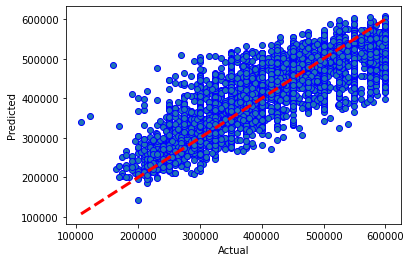

In [48]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred, edgecolors=(0, 0, 1))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
ax.set_ylabel('Predicted')
ax.set_xlabel('Actual')
#ax.title.set_text(f'CV Chosen best option ({calculated_best_pipe[1]})')
plt.show()

In [49]:
if not_catboost:
    def custom_model_and_predictions(model, graph_params, X_train, y_train, X_test):
        graph_model = model
        graph_model.set_params(**graph_params)
        graph_model.fit(X_train, y_train)
        y_pred_graph = model.predict(X_test)

        return model, y_pred_graph


    best_model_count = 10 if not quick_mode else 2
    best_model_count = 3 if not quick_mode else 1
    best_models = {}
    best_model_predictions = {}
    best_model_scores = {}

    showable_increment = total_fits // (4 if not quick_mode else 2)
    for i in range(0, total_fits, showable_increment):
        if debug_mode or True: print(f'{i} ==> {i}')

        if i == 0:
            fitted_graph_model = crossval_runner.best_estimator_
            y_pred_graph = y_pred
        else:
            graph_pipe_params = cv_results_df_sorted['params'][i]
            print(graph_pipe_params)
            # would always return the best! graph_pipe_params = cv_results_df_sorted.loc[cv_results_df_sorted['rank_test_score'] == 1, 'params'].values[0]

            graph_params = {}
            for key, value in graph_pipe_params.items():
                graph_params[key.replace('model__', '')] = value

            fitted_graph_model, y_pred_graph = custom_model_and_predictions(make_pipeline(), graph_pipe_params, X_train,
                                                                            y_train, X_test)

        best_models[i] = fitted_graph_model[-1].get_params()
        best_model_predictions[i] = y_pred_graph
        best_model_scores[i] = fitted_graph_model.score(X_test, y_test)

    if debug_mode or True: print(f'{-1} ==> {-1}')
    graph_pipe_params = cv_results_df_sorted['params'][total_fits - 1]
    print(graph_pipe_params)
    graph_params = {}
    for key, value in graph_pipe_params.items():
        graph_params[key.replace('model__', '')] = value
    fitted_graph_model, y_pred_graph = custom_model_and_predictions(make_pipeline(), graph_pipe_params, X_train,
                                                                    y_train, X_test)
    best_models[-1] = fitted_graph_model[-1].get_params()
    best_model_predictions[-1] = y_pred_graph
    best_model_scores[-1] = fitted_graph_model.score(X_test, y_test)


0 ==> 0
6 ==> 6
{'model__verbosity': 1, 'model__tree_method': 'auto', 'model__subsample': 0.5, 'model__objective': 'reg:squarederror', 'model__n_jobs': 3, 'model__n_estimators': 50, 'model__min_child_weight': 0.5, 'model__max_depth': 8, 'model__max_delta_step': 0.01, 'model__learning_rate': None, 'model__gamma': 100, 'model__early_stopping_rounds': None, 'model__booster': 'gblinear'}
[09:42:12] WARNING: ../src/learner.cc:627: 
Parameters: { "gamma", "max_delta_step", "max_depth", "min_child_weight", "subsample", "tree_method" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


12 ==> 12
{'model__verbosity': 1, 'model__tree_method': 'approx', 'model__subsample': 0.5, 'model__objective': 'reg:squarederror', 'model__n_jobs': 3, 'model__n_estimators': 50, 

In [50]:
cv_results_df_sorted if not_catboost else ''

,params2,rank_test_score,mean_test_score,mean_fit_time,mean_score_time,params
0,1/auto/1/reg:squarederror/3/150/5/6/0/None/Non...,1,0.676124,11.474795,0.512172,"{'model__verbosity': 1, 'model__tree_method': ..."
1,1/approx/0.5/reg:squarederror/3/125/2/8/0/None...,2,0.672429,8.033130,0.722349,"{'model__verbosity': 1, 'model__tree_method': ..."
2,1/approx/1/reg:squarederror/3/50/0.1/3/0/None/...,3,0.605534,0.845797,0.253274,"{'model__verbosity': 1, 'model__tree_method': ..."
3,1/auto/0.1/reg:squarederror/3/100/2/3/0/None/1...,4,0.600516,0.573249,0.025057,"{'model__verbosity': 1, 'model__tree_method': ..."
4,1/auto/0.1/reg:squarederror/3/75/5/8/0/None/No...,5,0.579094,1.648533,0.027557,"{'model__verbosity': 1, 'model__tree_method': ..."
5,1/approx/0.5/reg:squarederror/3/100/0.5/1/0/No...,6,0.504167,2.240248,0.303164,"{'model__verbosity': 1, 'model__tree_method': ..."
6,1/auto/0.5/reg:squarederror/3/50/0.5/8/0.01/No...,7,0.329080,0.245367,0.008087,"{'model__verbosity': 1, 'model__tree_method': ..."
7,1/hist/0.1/reg:squarederror/3/50/2/8/0.1/None/...,8,0.329080,0.242281,0.006673,"{'model__verbosity': 1, 'model__tree_method': ..."
8,1/auto/0.1/reg:squarederror/3/150/0.1/3/0.9/No...,9,0.329080,0.429773,0.003189,"{'model__verbosity': 1, 'model__tree_method': ..."
9,1/hist/0/reg:squarederror/3/150/2/3/0.3/None/1...,10,0.329080,0.560075,0.003511,"{'model__verbosity': 1, 'model__tree_method': ..."


In [51]:
cv_results_df_sorted['params']  if not_catboost and debug_mode else ''

''

In [52]:
cv_results_df_sorted['params'][0] if not_catboost else ''

{'model__verbosity': 1,
 'model__tree_method': 'auto',
 'model__subsample': 1,
 'model__objective': 'reg:squarederror',
 'model__n_jobs': 3,
 'model__n_estimators': 150,
 'model__min_child_weight': 5,
 'model__max_depth': 6,
 'model__max_delta_step': 0,
 'model__learning_rate': None,
 'model__gamma': None,
 'model__early_stopping_rounds': None,
 'model__booster': 'dart'}

In [53]:
best_models if not_catboost else ''

{0: {'objective': 'reg:squarederror',
  'base_score': 0.5,
  'booster': 'dart',
  'callbacks': None,
  'colsample_bylevel': 1,
  'colsample_bynode': 1,
  'colsample_bytree': 1,
  'early_stopping_rounds': None,
  'enable_categorical': False,
  'eval_metric': None,
  'gamma': 0,
  'gpu_id': -1,
  'grow_policy': 'depthwise',
  'importance_type': None,
  'interaction_constraints': '',
  'learning_rate': 0.300000012,
  'max_bin': 256,
  'max_cat_to_onehot': 4,
  'max_delta_step': 0,
  'max_depth': 6,
  'max_leaves': 0,
  'min_child_weight': 5,
  'missing': nan,
  'monotone_constraints': '()',
  'n_estimators': 150,
  'n_jobs': 3,
  'num_parallel_tree': 1,
  'predictor': 'auto',
  'random_state': 20,
  'reg_alpha': 0,
  'reg_lambda': 1,
  'sampling_method': 'uniform',
  'scale_pos_weight': 1,
  'subsample': 1,
  'tree_method': 'auto',
  'validate_parameters': 1,
  'verbosity': 1,
  'seed': 20},
 6: {'objective': 'reg:squarederror',
  'base_score': 0.5,
  'booster': 'gblinear',
  'callbacks':

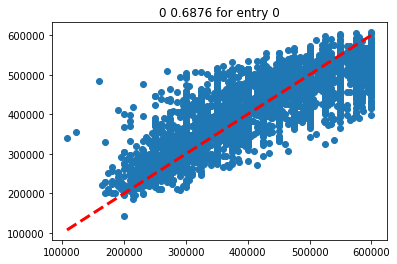

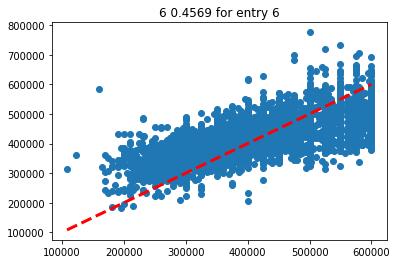

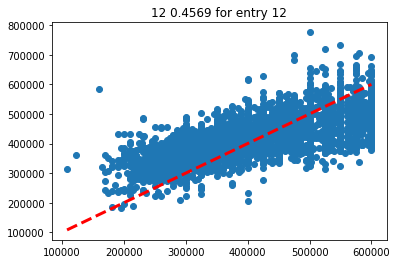

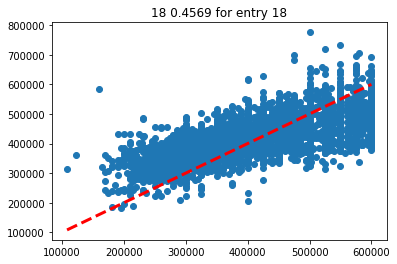

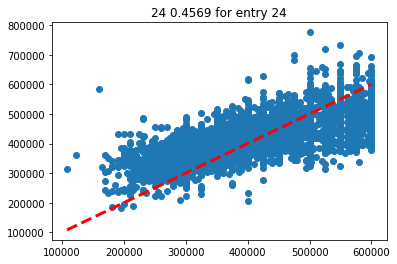

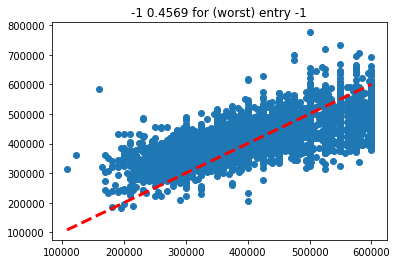

In [54]:
if not_catboost:
    for i in best_model_scores.keys():
        if i >= 0:
            plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
            plt.scatter(y_test, best_model_predictions[i])
            # plt.title(str(i) + " " + str(round(best_model_scores[i], 4)) + " for " + str(best_models[i]))
            if len(best_models[i].keys()) < 30:
                plt.title(str(i) + " " + str(round(best_model_scores[i], 4)) + " for " + str(best_models[i]))
            else:
                plt.title(str(i) + " " + str(round(best_model_scores[i], 4)) + " for entry " + str(i))
            plt.show()

    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
    plt.scatter(y_test, best_model_predictions[-1])
    # plt.title(str(i) + " " + str(round(best_model_scores[i], 4)) + " for " + str(best_models[i]))
    if len(best_models[i].keys()) < 30:
        plt.title(str(i) + " " + str(round(best_model_scores[-1], 4)) + " for " + str(best_models[-1]))
    else:
        plt.title(str(i) + " " + str(round(best_model_scores[-1], 4)) + " for (worst) entry " + str(i))

    plt.show()

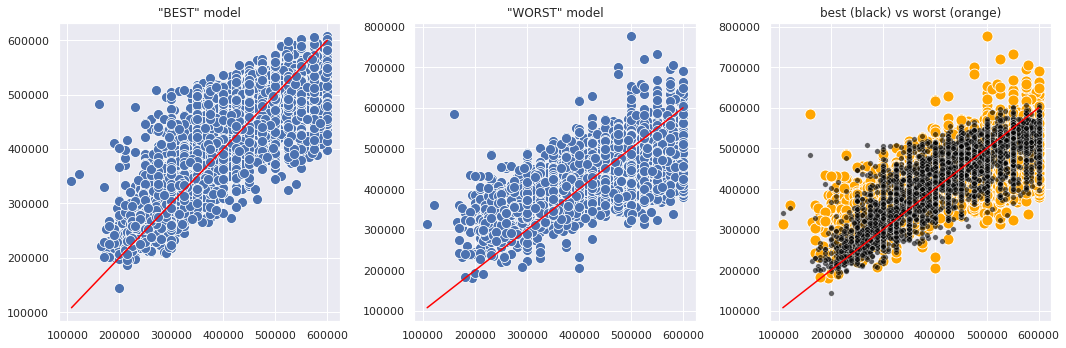

In [55]:
if not_catboost:
    sns.set_theme(font_scale=2, rc=None)
    sns.set_theme(font_scale=1, rc=None)

    fig, axes = plt.subplots(ncols=3, figsize=(15, 5))

    plt.subplots_adjust(hspace=0.2)
    plt.subplots_adjust(wspace=0.2)

    #.flatten()
    coordinates = axes[0]
    sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], ax=axes[0], color='red')
    sns.scatterplot(x=y_test.flatten(), y=best_model_predictions[0].flatten(), ax=axes[0],
                    s=100).set(title=f'"BEST" model')

    sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], ax=axes[1], color='red')
    sns.scatterplot(x=y_test.flatten(), y=best_model_predictions[-1].flatten(), ax=axes[1],
                    s=100).set(title=f'"WORST" model')

    sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], ax=axes[2], color='red')
    sns.scatterplot(x=y_test.flatten(), y=best_model_predictions[-1].flatten(), ax=axes[2],
                    s=120, color='orange')
    sns.scatterplot(x=y_test.flatten(), y=best_model_predictions[0].flatten(), ax=axes[2],
                    s=30, alpha=0.6, color='black').set(
        title='best (black) vs worst (orange)')
    #title='best (orange) vs worst (black)')

    fig.tight_layout()
    plt.show()

In [56]:
if not_catboost:
    cv_best_model_fit_time = cv_results_df_sorted.iloc[0]["mean_fit_time"]
cv_best_model_fit_time if not_catboost else ''

11.4747953414917

In [57]:
# <catboost.core.CatBoostRegressor object at 0x7fb167387490>
# {'depth': 6}
# defaultdict(<class 'list'>, {'iterations': [0, 1, 2],
# 'test-RMSE-mean': [396884.9605444017, 359548.6632536235, 326027.84885587444],
# 'test-RMSE-std': [308.9495320039113, 260.0967808594464, 219.65856329246023],
# 'train-RMSE-mean': [396884.77936957515, 359542.3612912551, 326018.9404460669],
# 'train-RMSE-std': [91.44140078375503, 86.77961380623475, 69.4038638987425]})

cv_best_model_fit_time = cv_results_df_sorted.iloc[0]["mean_fit_time"] if not_catboost else 999

DD2 = "(" + ",".join(DATA_DETAIL) + ")" if len(DATA_DETAIL) >= 1 else ""
key = f'{ALGORITHM} - {ALGORITHM_DETAIL}{DD2} (v{VERSION})'.lower()

results = {
    '_score': score,
    'R square Accuracy': R2,
    'Mean Absolute Error Accuracy': MAE,
    'Mean Squared Error Accuracy': MSE,
    'Root Mean Squared Error': RMSE,
    '_train time': cv_best_model_fit_time,
    'random_state': RANDOM_STATE,
    'date': str(datetime.now()),
    '_params': crossval_runner.best_params_ if not_catboost else cat_params,
    'run_env': run_env
}

if run_env not in ['colab']:
    results_json = get_results()
    this_model_is_best = update_results(results_json, results, key)

print(key)

xg boost - random search (v06)


In [58]:
crossval_runner.best_estimator_  if not_catboost else ''

Pipeline(steps=[('std_scaler', StandardScaler()),
                ('model',
                 XGBRegressor(base_score=0.5, booster='dart', callbacks=None,
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              gamma=0, gpu_id=-1, grow_policy='depthwise',
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.300000012, max_bin=256,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=6, max_leaves=0, min_child_weight=5,
                              missing=nan, monotone_constraints='()',
                              n_estimators=150, n_jobs=3, num_parallel_tree=1,
                              predictor='auto', random_state=20, reg_alpha=0,
                              reg_lambda=1, ...))])

In [59]:
if this_model_is_best:
    with open(f'../../../models/optimised_model_{ALGORITHM}_v{VERSION}{DD2}.pkl', 'wb') as f:
        if not_catboost:
            pickle.dump(crossval_runner.best_estimator_, f)
        else:
            pickle.dump(starter_model, f)
        print('pickled new version of model')
        print(results_json[key]['_score'], 'is new best score')
        #print(results_json[key]['_score'], 'is an improvement on', results_json[key]['second best score'])
else:
    print("not updated saved model, the previous run was better")
    print(results_json[key]['best score'], 'better than or equal to', results_json[key]['_score'])

pickled new version of model
0.6876112801153882 is new best score


In [60]:
if 'tree' in ALGORITHM.lower() or 'forest' in ALGORITHM.lower() or 'boost' in ALGORITHM.lower():
    feature_importances = crossval_runner.best_estimator_[-1].feature_importances_ if not_catboost else starter_model.get_feature_importance()
    #std = np.std([tree.feature_importances_ for tree in model.estimators_], axis = 0)

    indices = np.argsort(feature_importances)[::-1]

    print('Feature Ranking:')

    for f in range(X_train.shape[1]):
        print('%d. features %d (%f)' % (f + 1, indices[f], feature_importances[indices[f]]),
              df_features.columns[indices[f] + 1])
else:
    print(f'{ALGORITHM} does not have feature_importances, skipping')

Feature Ranking:
1. features 9 (0.387897) tenure.tenureType_LEASEHOLD
2. features 0 (0.266844) bedrooms
3. features 1 (0.147389) bathrooms
4. features 5 (0.047679) latitude_deviation
5. features 8 (0.047415) tenure.tenureType_FREEHOLD
6. features 4 (0.038500) location.longitude
7. features 6 (0.024923) longitude_deviation
8. features 3 (0.016826) location.latitude
9. features 10 (0.011289) tenure.tenureType_SHARE_OF_FREEHOLD
10. features 2 (0.008218) nearestStation
11. features 7 (0.003020) tenure.tenureType_COMMONHOLD


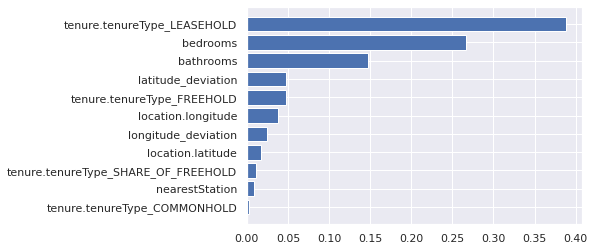

In [61]:
if 'tree' in ALGORITHM.lower() or 'forest' in ALGORITHM.lower() or 'boost' in ALGORITHM.lower():
    indices = np.argsort(feature_importances)

    fig, ax = plt.subplots()
    ax.barh(range(len(feature_importances)), feature_importances[indices])
    ax.set_yticks(range(len(feature_importances)))
    _ = ax.set_yticklabels(df_features.columns[[c + 1 for c in indices]])
else:
    print(f'{ALGORITHM} does not have feature_importances, skipping')